In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import seaborn as sns

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [2]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)

# Dataset

In [3]:
batch_size = 64

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

100%|██████████| 170M/170M [02:49<00:00, 1.00MB/s]   


In [6]:
len(trainset), len(testset)

(50000, 10000)

In [7]:
trainset.data.shape, testset.data.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [8]:
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

## Visualize

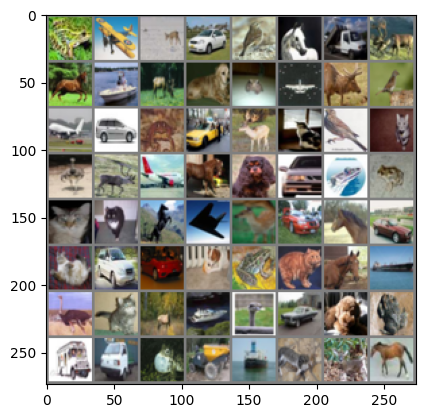

In [9]:
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))

In [10]:
class_names = trainset.classes
print(class_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


# Build Model

## CNN

In [13]:
# Your code here
class CNNModel(nn.Module):
    def __init__(self, num_classes=10):
        super(CNNModel, self).__init__()
        # Conv2d(in_channels, out_channels, kernel_size)
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # Giảm size từ 32x32 xuống 16x16
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 512),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

## RNN

In [12]:
class ImageRNN(nn.Module):
    def __init__(self, num_classes=10, hidden_dims=128):
        super(ImageRNN, self).__init__()
        self.hidden_dims = hidden_dims
        
        # RNN Layer: input_size = 32 pixels * 3 channels = 96
        # hidden_dims = 128
        self.rnn = nn.RNN(input_size=96, 
                          hidden_size=hidden_dims, 
                          num_layers=1, 
                          batch_first=True)
        
        # Fully Connected layers theo sơ đồ 2
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dims, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        # x: (Batch, 3, 32, 32) -> Chuyển thành (Batch, Timesteps=32, Input=96)
        batch_size = x.size(0)
        x = x.permute(0, 2, 3, 1).contiguous().view(batch_size, 32, -1)
        
        # h_0 mặc định là zeros
        out, h_n = self.rnn(x)
        
        # Lấy trạng thái ẩn cuối cùng để phân loại
        last_hidden = h_n[-1] 
        return self.classifier(last_hidden)

## LSTM

In [11]:
# Your code here
class ImageLSTM(nn.Module):
    def __init__(self, num_classes=10, hidden_dims=128):
        super(ImageLSTM, self).__init__()
        self.hidden_dims = hidden_dims
        
        # LSTM Layer
        # input_size = 96 (32x3), hidden_size = 128
        self.lstm = nn.LSTM(input_size=96, 
                            hidden_size=hidden_dims, 
                            num_layers=1, 
                            batch_first=True)
        
        # Lớp phân loại sau khi đi qua 512 nodes
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dims, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        # Biến đổi input ảnh thành chuỗi timesteps
        batch_size = x.size(0)
        x = x.permute(0, 2, 3, 1).contiguous().view(batch_size, 32, -1)
        
        # LSTM trả về (output, (h_n, c_n))
        # Chúng ta sử dụng h_n (hidden state cuối cùng)
        _, (h_n, c_n) = self.lstm(x)
        
        return self.classifier(h_n[-1])

## Transformer (ViT)

In [14]:
# Your code here
class ViTModel(nn.Module):
    def __init__(self, num_classes=10, patch_size=4, embed_dim=128, num_heads=8):
        super(ViTModel, self).__init__()
        # Patching & Linear Projection
        self.patch_size = patch_size
        num_patches = (32 // patch_size) ** 2
        self.projection = nn.Linear(patch_size * patch_size * 3, embed_dim)
        
        # Transformer Encoder (depth=1)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, 
            nhead=num_heads, 
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=1)
        
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, 512),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        # 1. Tạo patches: (B, 3, 32, 32) -> (B, num_patches, patch_flatten_dim)
        B, C, H, W = x.shape
        x = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        x = x.contiguous().view(B, C, -1, self.patch_size, self.patch_size)
        x = x.permute(0, 2, 3, 4, 1).contiguous().view(B, -1, self.patch_size * self.patch_size * C)
        
        # 2. Linear Projection
        x = self.projection(x)
        
        # 3. Transformer Encoder
        x = self.encoder(x)
        
        # 4. Global Average Pooling (lấy trung bình các patches)
        x = x.mean(dim=1)
        
        return self.classifier(x)

# Set up hyperparameter

In [16]:
models = {
    'CNN': CNNModel().to(device),
    'RNN': ImageRNN().to(device),
    'LSTM': ImageLSTM().to(device),
    'Transformer': ViTModel().to(device)
}

In [17]:
epochs = 10
learning_rate = 0.001
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# Training

In [18]:
# Function to compute loss and accuracy for test set
def evaluate(model, testloader, criterion):
    model.eval()
    test_loss = 0.0
    running_correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

    accuracy = 100 * running_correct / total
    test_loss = test_loss / len(testloader)
    return test_loss, accuracy

In [19]:
def train_model(model, criterion, optimizer):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        running_correct = 0   # to track number of correct predictions
        total = 0             # to track total number of samples

        for i, (inputs, labels) in enumerate(trainloader, 0):
            # Move inputs and labels to the device
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Determine class predictions and track accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            running_correct += (predicted == labels).sum().item()


        epoch_accuracy = 100 * running_correct / total
        epoch_loss = running_loss / (i + 1)

        test_loss, test_accuracy = evaluate(model, testloader, criterion)
        print(f"Epoch [{(epoch + 1):3}/{epochs:3}] \t Loss: {epoch_loss:<11.5f} Accuracy: {epoch_accuracy:.2f}% \t Test Loss: {test_loss:<11.5f} Test Accuracy: {test_accuracy:.2f}%")

        # save for plot
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

In [20]:
criterion = nn.CrossEntropyLoss()
for model_name, model in models.items():
    if model_name == 'CNN':
        print(f"Training {model_name}")
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        train_model(model, criterion, optimizer)

Training CNN
Epoch [  1/ 10] 	 Loss: 1.37109     Accuracy: 51.34% 	 Test Loss: 1.10329     Test Accuracy: 60.97%
Epoch [  2/ 10] 	 Loss: 0.94048     Accuracy: 67.12% 	 Test Loss: 0.97328     Test Accuracy: 66.38%
Epoch [  3/ 10] 	 Loss: 0.77777     Accuracy: 73.07% 	 Test Loss: 0.93868     Test Accuracy: 68.65%
Epoch [  4/ 10] 	 Loss: 0.62981     Accuracy: 77.93% 	 Test Loss: 0.91206     Test Accuracy: 69.89%
Epoch [  5/ 10] 	 Loss: 0.48284     Accuracy: 83.08% 	 Test Loss: 1.03088     Test Accuracy: 68.77%
Epoch [  6/ 10] 	 Loss: 0.34994     Accuracy: 87.67% 	 Test Loss: 1.11749     Test Accuracy: 69.27%
Epoch [  7/ 10] 	 Loss: 0.25479     Accuracy: 90.85% 	 Test Loss: 1.42147     Test Accuracy: 66.41%
Epoch [  8/ 10] 	 Loss: 0.19948     Accuracy: 92.87% 	 Test Loss: 1.61099     Test Accuracy: 66.68%
Epoch [  9/ 10] 	 Loss: 0.16207     Accuracy: 94.19% 	 Test Loss: 1.78337     Test Accuracy: 66.79%
Epoch [ 10/ 10] 	 Loss: 0.13599     Accuracy: 95.27% 	 Test Loss: 1.95277     Test Accu

In [21]:
criterion = nn.CrossEntropyLoss()
for model_name, model in models.items():
    if model_name == 'RNN':
        print(f"Training {model_name}")
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        train_model(model, criterion, optimizer)

Training RNN
Epoch [  1/ 10] 	 Loss: 1.98008     Accuracy: 26.96% 	 Test Loss: 1.89960     Test Accuracy: 32.08%
Epoch [  2/ 10] 	 Loss: 1.95007     Accuracy: 28.94% 	 Test Loss: 1.90401     Test Accuracy: 30.14%
Epoch [  3/ 10] 	 Loss: 1.94749     Accuracy: 28.80% 	 Test Loss: 1.88406     Test Accuracy: 30.21%
Epoch [  4/ 10] 	 Loss: 1.88787     Accuracy: 30.94% 	 Test Loss: 2.06613     Test Accuracy: 23.59%
Epoch [  5/ 10] 	 Loss: 1.92672     Accuracy: 29.30% 	 Test Loss: 1.89625     Test Accuracy: 29.68%
Epoch [  6/ 10] 	 Loss: 1.92900     Accuracy: 29.40% 	 Test Loss: 1.94788     Test Accuracy: 28.93%
Epoch [  7/ 10] 	 Loss: 1.93082     Accuracy: 29.24% 	 Test Loss: 1.89600     Test Accuracy: 29.53%
Epoch [  8/ 10] 	 Loss: 1.89395     Accuracy: 30.89% 	 Test Loss: 1.82458     Test Accuracy: 32.97%
Epoch [  9/ 10] 	 Loss: 1.86222     Accuracy: 31.98% 	 Test Loss: 1.83430     Test Accuracy: 32.24%
Epoch [ 10/ 10] 	 Loss: 1.88711     Accuracy: 30.87% 	 Test Loss: 1.94015     Test Accu

In [ ]:
criterion = nn.CrossEntropyLoss()
for model_name, model in models.items():
    if model_name == 'LSTM':
        print(f"Training {model_name}")
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        train_model(model, criterion, optimizer)

In [22]:
criterion = nn.CrossEntropyLoss()
for model_name, model in models.items():
    if model_name == 'Transformer':
        print(f"Training {model_name}")
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        train_model(model, criterion, optimizer)

Training Transformer
Epoch [  1/ 10] 	 Loss: 1.66561     Accuracy: 38.37% 	 Test Loss: 1.48844     Test Accuracy: 46.17%
Epoch [  2/ 10] 	 Loss: 1.43739     Accuracy: 47.82% 	 Test Loss: 1.38500     Test Accuracy: 49.98%
Epoch [  3/ 10] 	 Loss: 1.33687     Accuracy: 51.77% 	 Test Loss: 1.38762     Test Accuracy: 50.03%
Epoch [  4/ 10] 	 Loss: 1.27547     Accuracy: 54.14% 	 Test Loss: 1.26793     Test Accuracy: 54.83%
Epoch [  5/ 10] 	 Loss: 1.22353     Accuracy: 56.08% 	 Test Loss: 1.24315     Test Accuracy: 56.09%
Epoch [  6/ 10] 	 Loss: 1.18340     Accuracy: 57.57% 	 Test Loss: 1.19544     Test Accuracy: 57.65%
Epoch [  7/ 10] 	 Loss: 1.14180     Accuracy: 58.97% 	 Test Loss: 1.22558     Test Accuracy: 55.46%
Epoch [  8/ 10] 	 Loss: 1.10683     Accuracy: 60.37% 	 Test Loss: 1.16750     Test Accuracy: 58.21%
Epoch [  9/ 10] 	 Loss: 1.07414     Accuracy: 61.35% 	 Test Loss: 1.15479     Test Accuracy: 58.45%
Epoch [ 10/ 10] 	 Loss: 1.03804     Accuracy: 62.86% 	 Test Loss: 1.15071     T